In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
%matplotlib inline

In [2]:
# gather all radiomic data from primary and recurred tumors
rootdir = '/Users/shuang/Documents/Proj_Radiomics/Data/her2'

# get radiomics of all the primary tumor data
fname1 = '{}/her2_Analysis/PETMRI/PETbinwidth0.1_MRItp2_binwidth5/data_all.csv'.format(rootdir)
df_prim_all = pd.read_csv(fname1)

# print(df_prim_all.columns.tolist())

# find all PET radiomics
pat = re.compile('_pet')
feat_names = [ss for ss in df_prim_all.columns.tolist() if re.search('([\w.]+)_pet',ss)]
new_feat_names = [re.search('([\w.]+)_pet', ss).group(1) for ss in df_prim_all.columns.tolist() if re.search('([\w.]+)_pet', ss)]
newer_feat_names = [re.search('([\w.]+)_avg', ss).group(1) if re.search('([\w.]+)_avg', ss) else ss for ss in new_feat_names]

the_col_names = feat_names + ['ptid_side']
df_prim = df_prim_all.loc[:,the_col_names]

# change feature name
col_dict = dict(zip(feat_names, newer_feat_names))
df_prim.rename(col_dict, axis='columns',inplace=True)
df_prim['tumor_type'] = 'Primary'
# print(df_prim.columns.tolist())

json_dir = '{}/her2_ImageFeatures/IsoVoxelSize'.format(rootdir)
all_jsons = glob.glob('{}/*.json'.format(json_dir))

df_recur = pd.DataFrame()
for jj in all_jsons:
    df_tmp = pd.read_json(jj)
    df_recur = df_recur.append(df_tmp, ignore_index=True)
df_recur['FOstats_min'] = df_recur['FOstats_minmax'].apply(lambda x: x[0])
df_recur['FOstats_max'] = df_recur['FOstats_minmax'].apply(lambda x: x[1])
df_recur.drop(columns=['FOstats_minmax'],inplace=True)

# get the average of texture features

pat = re.compile('texture_')
texture_cols = [ss for ss in df_recur.columns.tolist() if pat.match(ss)]
for tc in texture_cols:
    df_recur[tc +'_avg'] = df_recur[tc].apply(np.mean)
    df_recur.drop(tc,axis=1,inplace=True)    
df_recur['tumor_type'] = df_recur['tumor_tag'].map(lambda x: '_'.join(['Recur',x]))
df_recur['ptid_side'] = df_recur[['pt_id','breast_side']].apply(lambda x: '{}_{}'.format(x[0], x[1]), axis=1)
newer_feat_names = [re.search('([\w.]+)_avg', ss).group(1) if re.search('([\w.]+)_avg', ss) else ss for ss in df_recur.columns.tolist()]
col_dict = dict(zip(df_recur.columns.tolist(), newer_feat_names))
df_recur.rename(col_dict, axis='columns',inplace=True)

col_of_interest = df_prim.columns.tolist()
df_recur_oi = df_recur.loc[:,col_of_interest]
df_prim_oi = df_prim.loc[:,col_of_interest]

# combine primary and recur tumor DFs
df_all = pd.concat([df_prim_oi, df_recur_oi], ignore_index=True)
print(df_all)


     FOstats_energy  FOstats_entropy  FOstats_kurtosis  FOstats_mean  \
0     197984.031250         5.536868          5.234993      3.525060   
1     211952.109375         5.470107          5.270049      3.174406   
2         57.455063         1.763697          2.370392      1.091445   
3       7258.604492         5.099894          2.806678      2.700307   
4      57107.488281         5.084719          7.894037      2.232625   
5        983.184448         3.355637          3.422115      1.594757   
6       8460.021484         5.427511          5.978713      2.856201   
7      17500.703125         4.632359          5.544690      2.255796   
8      48165.585938         5.266244          2.678233      2.761572   
9       2454.211670         4.033516          4.632780      1.364780   
10      2425.740234         2.297966          5.669534      0.857146   
11      1980.467773         4.311808          3.249635      1.943283   
12       173.288330         2.303275          3.030634      0.60

In [62]:
ptid_sides = list(df_recur_oi.ptid_side.unique())
print(ptid_sides)

df_corr_all = pd.DataFrame()
for ps in ptid_sides:
    print(ps)
    df1 = df_all[df_all['ptid_side'] == ps]
    val_vars = set(df1.columns.tolist()).symmetric_difference(['ptid_side','tumor_type'])
    df2 = pd.melt(df1, id_vars=['ptid_side','tumor_type'], value_vars=val_vars, var_name='Radiomics')
    df3 = df2.pivot(index='Radiomics',columns='tumor_type',values='value')
    df3.reset_index(inplace=True)
    corr_mat = df3.corr()
    tmp1 = corr_mat.loc['Primary',:]
    print(tmp1.index.tolist())
    the_ind = [ss for ss in tmp1.index.tolist() if ss != 'Primary']
    tmp2 = tmp1[the_ind].reset_index()
    tmp2['prim_recur pair name'] = tmp2['tumor_type'].map(lambda x: 'Primary_{}'.format(x))
    print(tmp2)
    tmp2.drop(columns=['tumor_type'],inplace=True)
    tmp2['Tumor Pair Index'] = range(1,len(tmp2)+1)
    tmp2['pt_id'] = ps
    tmp2.rename(columns={'Primary':'Pearson Correlation'},inplace=True)
    df_corr_all = pd.concat([df_corr_all, tmp2], ignore_index=True)
print(df_corr_all)


['116_L', '117_L', '123_L', '13_R', '25_L', '30_L', '69_L', '99_R']
116_L
['Primary', u'Recur_Brain1', u'Recur_Brain2']
     tumor_type   Primary  prim_recur pair name
0  Recur_Brain1  0.004842  Primary_Recur_Brain1
1  Recur_Brain2  0.166471  Primary_Recur_Brain2
117_L
['Primary', u'Recur_Lung']
   tumor_type   Primary prim_recur pair name
0  Recur_Lung  0.998933   Primary_Recur_Lung
123_L
['Primary', u'Recur_LRib', u'Recur_RRib']
   tumor_type   Primary prim_recur pair name
0  Recur_LRib  0.991707   Primary_Recur_LRib
1  Recur_RRib  0.957516   Primary_Recur_RRib
13_R
['Primary', u'Recur_Illiac', u'Recur_InternalMammoNode', u'Recur_Sacrum', u'Recur_SuperclavicularNode']
                  tumor_type   Primary               prim_recur pair name
0               Recur_Illiac  0.999905               Primary_Recur_Illiac
1    Recur_InternalMammoNode  0.999985    Primary_Recur_InternalMammoNode
2               Recur_Sacrum  0.999641               Primary_Recur_Sacrum
3  Recur_SuperclavicularN

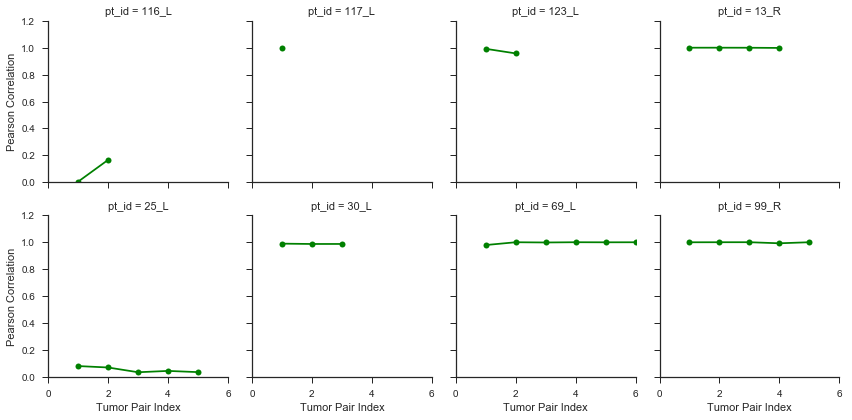

In [66]:
sns.set(style="ticks")
grid = sns.FacetGrid(df_corr_all, col="pt_id", hue="pt_id", col_wrap=4, size=3)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, 'Tumor Pair Index', 'Pearson Correlation', marker="o", ms=6, color='green')

# Adjust the tick positions and labels
grid.set(xlim=(0, 6), ylim=(0, 1.2))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)
plt.show()